In [1]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f, l
import matplotlib.pyplot as plt
from quantbullet.model import WrapperGAM
from quantbullet.model.feature import FeatureSpec, FeatureRole, Feature, DataType

# Generate sample data
np.random.seed(42)
n_samples = 200

# Create features
age = np.random.uniform(20, 80, n_samples)
income = np.random.uniform(20000, 120000, n_samples)
education = np.random.uniform(8, 20, n_samples)
level = np.random.choice(['highschool', 'bachelor', 'master', 'phd'], n_samples)

# Create target with non-linear relationships
happiness = (
    0.5 * np.sin((age - 40) / 10) +  # non-linear relationship with age
    0.3 * np.log(income / 30000) +   # log relationship with income
    0.2 * education +                # linear relationship with education
    0.1 * (level == 'phd').astype(float) +  # categorical effect
    np.random.normal(0, 0.5, n_samples)  # noise
)

# Create DataFrame
data = pd.DataFrame({
    'age': age,
    'income': income,
    'education': education,
    'level': level,
    'happiness': happiness
})

print("Sample data:")
print(data.head())

Sample data:
         age         income  education       level  happiness
0  42.472407   84203.164615   9.237486  highschool   1.953555
1  77.042858   28413.996500  18.830635    bachelor   3.506799
2  63.919637   36162.871409  14.063028         phd   2.879133
3  55.919509  109855.418853  17.917490    bachelor   4.280499
4  29.361118   80642.905966  11.840595  highschool   2.730791


In [2]:
features = FeatureSpec(
    features=[
        Feature(name='age', dtype=DataType.FLOAT, role=FeatureRole.MODEL_INPUT, specs={ "spline_order" : 3, "n_splines" : 6, "lam" : 0.1, "by" : "level" }),
        Feature(name='income', dtype=DataType.FLOAT, role=FeatureRole.MODEL_INPUT, specs={ "spline_order" : 3, "n_splines" : 6, "lam" : 0.1 } ),
        Feature(name='education', dtype=DataType.FLOAT, role=FeatureRole.MODEL_INPUT, specs={ "spline_order" : 3, "n_splines" : 6, "lam" : 0.1 } ),
        Feature(name='level', dtype=DataType.CATEGORY, role=FeatureRole.MODEL_INPUT ),
        Feature(name='happiness', dtype=DataType.FLOAT, role=FeatureRole.TARGET )
    ]
)

In [3]:
wgam = WrapperGAM( features )
wgam.fit( data, data['happiness'] )

WrapperGAM(LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(0) + s(0) + s(0) + s(1) + s(2) + f(3) + intercept, 
   tol=0.0001, verbose=False))

C:\Users\yimingz\repo\quantbullet\src\quantbullet\model\gam.py:308: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=by_name)


(<Figure size 1500x800 with 6 Axes>,
 array([<Axes: xlabel='age (by level)', ylabel='Partial Dependence'>,
        <Axes: xlabel='income', ylabel='Partial Dependence'>,
        <Axes: xlabel='education', ylabel='Partial Dependence'>,
        <Axes: xlabel='level', ylabel='Partial Dependence'>, <Axes: >,
        <Axes: >], dtype=object))

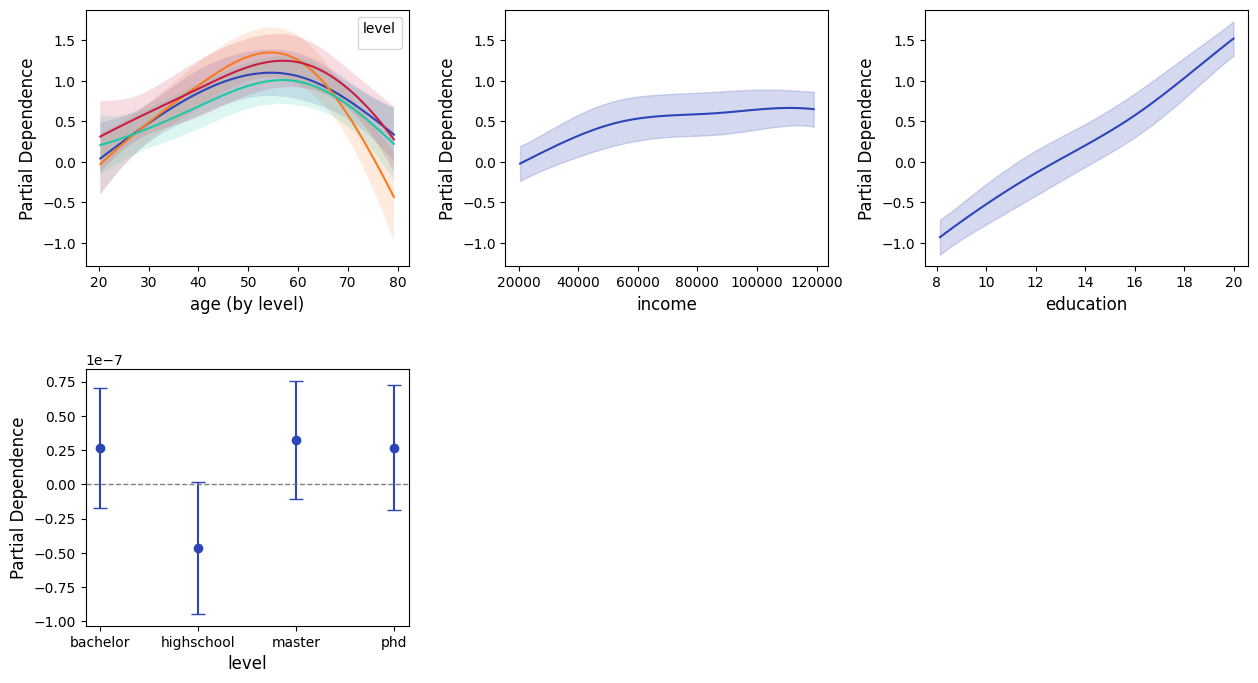

In [4]:
wgam.plot_partial_dependence( scale_y_axis=True )

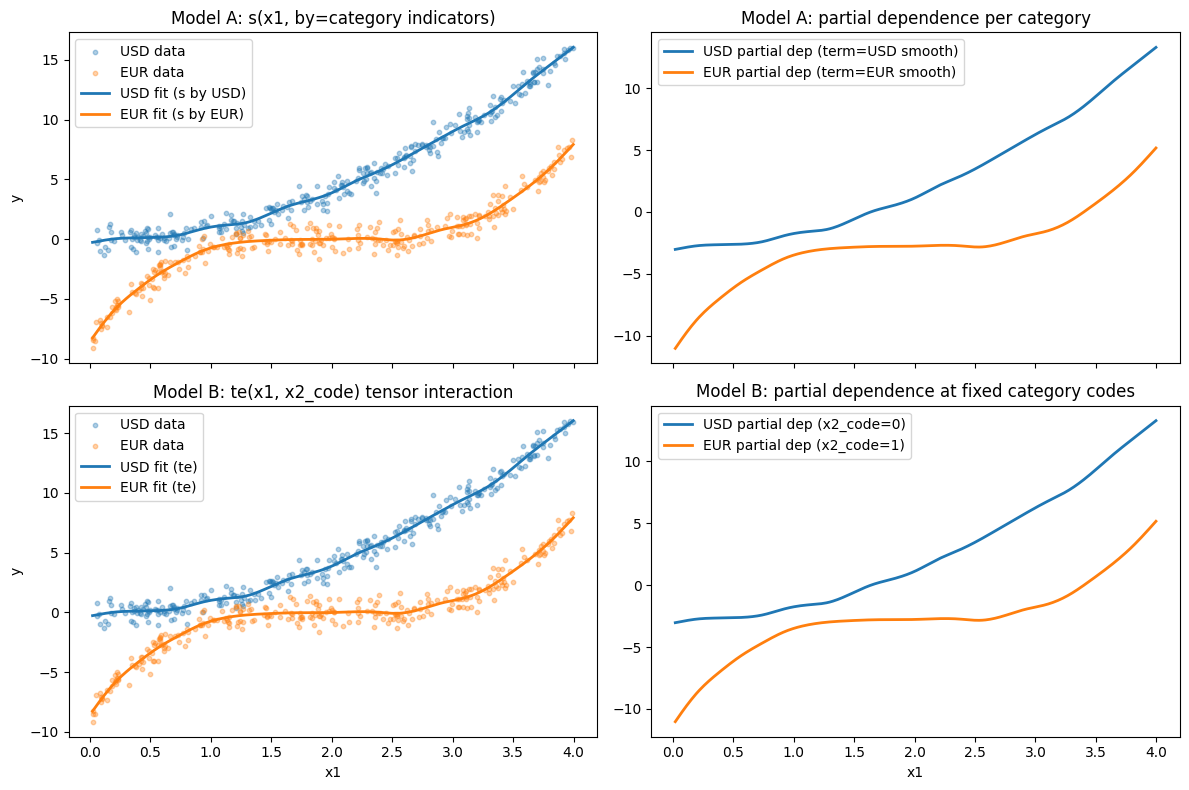

Model A (by)  pseudo-R2: 0.9843687535575434
Model B (te)  pseudo-R2: 0.9843687535575434


In [9]:
import numpy as np
import matplotlib.pyplot as plt

from pygam import LinearGAM, s, te

# -----------------------
# 1) Simulate data
# -----------------------
rng = np.random.default_rng(42)

n = 600
x1 = rng.uniform(0, 4, size=n)  # continuous /kənˈtɪnjuəs/
x2 = rng.choice(["USD", "EUR"], size=n, p=[0.5, 0.5])  # categorical /ˌkætəˈɡɔːrɪkəl/

# indicator /ˈɪndɪˌkeɪtər/ columns for "by" model
is_usd = (x2 == "USD").astype(int)
is_eur = (x2 == "EUR").astype(int)

# numeric code for tensor model (0/1)
x2_code = is_eur.astype(int)  # USD=0, EUR=1

# create two different curves + noise /nɔɪz/
eps = rng.normal(0, 0.6, size=n)

y = np.empty(n)
y[x2 == "USD"] = (x1[x2 == "USD"] ** 2) + eps[x2 == "USD"]
y[x2 == "EUR"] = ((x1[x2 == "EUR"] - 2) ** 3) + eps[x2 == "EUR"]

# X matrices
# For "by" model: columns = [x1, is_usd, is_eur]
X_by = np.column_stack([x1, is_usd, is_eur])

# For tensor model: columns = [x1, x2_code]
X_te = np.column_stack([x1, x2_code])

# -----------------------
# 2) Fit Model A: s(x1) by category (two separate smooths)
# -----------------------
# term0 uses by=is_usd; term1 uses by=is_eur
gam_by = LinearGAM(
    s(0, by=1, n_splines=25) + s(0, by=2, n_splines=25)
).fit(X_by, y)

# -----------------------
# 3) Fit Model B: tensor interaction te(x1, x2_code)
# -----------------------
# Note: x2_code is binary; using small splines in that dimension reduces weird smoothing.
gam_te = LinearGAM(
    te(0, 1, n_splines=[25, 2], spline_order=[3, 1])
).fit(X_te, y)

# -----------------------
# 4) Build grids for plotting
# -----------------------
xg = np.linspace(x1.min(), x1.max(), 300)

Xg_usd_by = np.column_stack([xg, np.ones_like(xg), np.zeros_like(xg)])
Xg_eur_by = np.column_stack([xg, np.zeros_like(xg), np.ones_like(xg)])

Xg_usd_te = np.column_stack([xg, np.zeros_like(xg)])  # USD=0
Xg_eur_te = np.column_stack([xg, np.ones_like(xg)])   # EUR=1

# predictions
pred_usd_by = gam_by.predict(Xg_usd_by)
pred_eur_by = gam_by.predict(Xg_eur_by)

pred_usd_te = gam_te.predict(Xg_usd_te)
pred_eur_te = gam_te.predict(Xg_eur_te)

# (optional) "partial dependence" style curves
# For by-model: term 0 corresponds to USD-smooth, term 1 corresponds to EUR-smooth
pd_usd_by = gam_by.partial_dependence(term=0, X=Xg_usd_by)
pd_eur_by = gam_by.partial_dependence(term=1, X=Xg_eur_by)

# For tensor-model: single term=0, evaluated at two fixed category codes
pd_usd_te = gam_te.partial_dependence(term=0, X=Xg_usd_te)
pd_eur_te = gam_te.partial_dependence(term=0, X=Xg_eur_te)

# -----------------------
# 5) Plot
# -----------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# (A1) data + fitted curves (by-model)
ax = axes[0, 0]
ax.scatter(x1[x2 == "USD"], y[x2 == "USD"], s=10, alpha=0.35, label="USD data")
ax.scatter(x1[x2 == "EUR"], y[x2 == "EUR"], s=10, alpha=0.35, label="EUR data")
ax.plot(xg, pred_usd_by, linewidth=2, label="USD fit (s by USD)")
ax.plot(xg, pred_eur_by, linewidth=2, label="EUR fit (s by EUR)")
ax.set_title("Model A: s(x1, by=category indicators)")
ax.legend()

# (A2) partial dependence (by-model)
ax = axes[0, 1]
ax.plot(xg, pd_usd_by, linewidth=2, label="USD partial dep (term=USD smooth)")
ax.plot(xg, pd_eur_by, linewidth=2, label="EUR partial dep (term=EUR smooth)")
ax.set_title("Model A: partial dependence per category")
ax.legend()

# (B1) data + fitted curves (tensor-model)
ax = axes[1, 0]
ax.scatter(x1[x2 == "USD"], y[x2 == "USD"], s=10, alpha=0.35, label="USD data")
ax.scatter(x1[x2 == "EUR"], y[x2 == "EUR"], s=10, alpha=0.35, label="EUR data")
ax.plot(xg, pred_usd_te, linewidth=2, label="USD fit (te)")
ax.plot(xg, pred_eur_te, linewidth=2, label="EUR fit (te)")
ax.set_title("Model B: te(x1, x2_code) tensor interaction")
ax.legend()

# (B2) partial dependence (tensor-model)
ax = axes[1, 1]
ax.plot(xg, pd_usd_te, linewidth=2, label="USD partial dep (x2_code=0)")
ax.plot(xg, pd_eur_te, linewidth=2, label="EUR partial dep (x2_code=1)")
ax.set_title("Model B: partial dependence at fixed category codes")
ax.legend()

for ax in axes[:, 0]:
    ax.set_ylabel("y")
for ax in axes[1, :]:
    ax.set_xlabel("x1")

plt.tight_layout()
plt.show()

print("Model A (by)  pseudo-R2:", gam_by.statistics_["pseudo_r2"]["explained_deviance"])
print("Model B (te)  pseudo-R2:", gam_te.statistics_["pseudo_r2"]["explained_deviance"])


## Three Categorical

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, te

rng = np.random.default_rng(42)

n = 900
x1 = rng.uniform(0, 4, size=n)

# 3-category categorical
x2 = rng.choice(["USD", "EUR", "GBP"], size=n)

# indicator variables (for by-spline)
is_usd = (x2 == "USD").astype(int)
is_eur = (x2 == "EUR").astype(int)
is_gbp = (x2 == "GBP").astype(int)

# numeric code (for tensor) — ⚠️ 引入“顺序假设”
x2_code = np.select(
    [x2 == "USD", x2 == "EUR", x2 == "GBP"],
    [0, 1, 2]
)

# three totally different curves
eps = rng.normal(0, 0.6, size=n)
y = np.empty(n)

y[x2 == "USD"] = x1[x2 == "USD"]**2 + eps[x2 == "USD"]
y[x2 == "EUR"] = (x1[x2 == "EUR"] - 2)**3 + eps[x2 == "EUR"]
y[x2 == "GBP"] = np.sin(2 * x1[x2 == "GBP"]) * 3 + eps[x2 == "GBP"]


In [11]:
X_by = np.column_stack([x1, is_usd, is_eur, is_gbp])

gam_by = LinearGAM(
    s(0, by=1, n_splines=25) +
    s(0, by=2, n_splines=25) +
    s(0, by=3, n_splines=25)
).fit(X_by, y)


In [12]:
X_te = np.column_stack([x1, x2_code])

gam_te = LinearGAM(
    te(0, 1, n_splines=[25, 3], spline_order=[3, 1])
).fit(X_te, y)


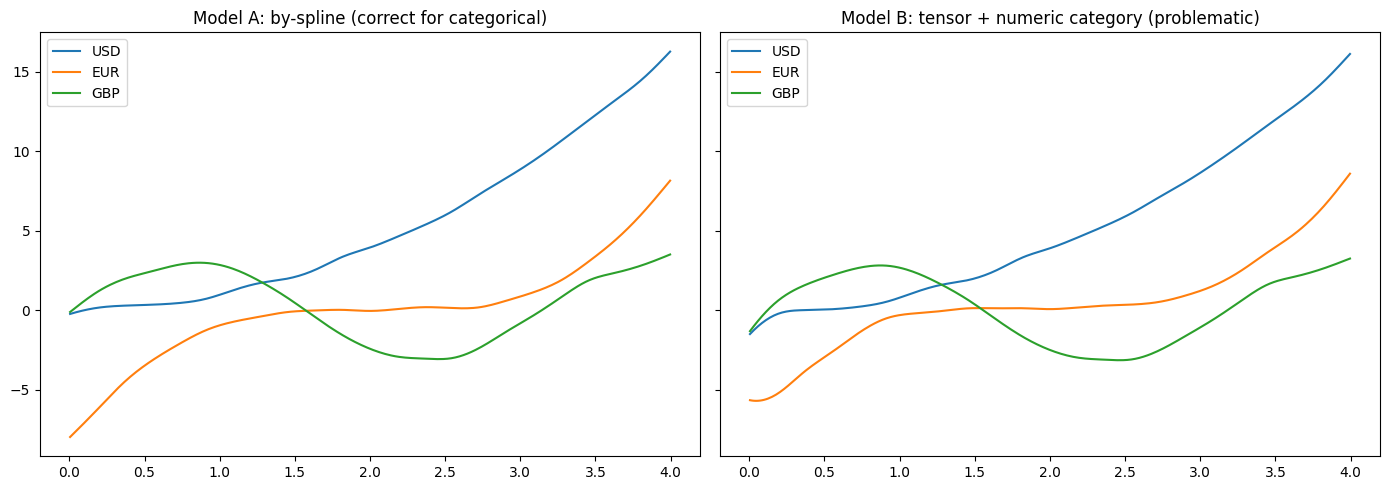

In [13]:
xg = np.linspace(x1.min(), x1.max(), 300)

# by-spline grids
Xg_usd_by = np.column_stack([xg, np.ones_like(xg), np.zeros_like(xg), np.zeros_like(xg)])
Xg_eur_by = np.column_stack([xg, np.zeros_like(xg), np.ones_like(xg), np.zeros_like(xg)])
Xg_gbp_by = np.column_stack([xg, np.zeros_like(xg), np.zeros_like(xg), np.ones_like(xg)])

# tensor grids
Xg_usd_te = np.column_stack([xg, np.zeros_like(xg)])
Xg_eur_te = np.column_stack([xg, np.ones_like(xg)])
Xg_gbp_te = np.column_stack([xg, np.full_like(xg, 2)])

# predictions
pred_by = {
    "USD": gam_by.predict(Xg_usd_by),
    "EUR": gam_by.predict(Xg_eur_by),
    "GBP": gam_by.predict(Xg_gbp_by),
}

pred_te = {
    "USD": gam_te.predict(Xg_usd_te),
    "EUR": gam_te.predict(Xg_eur_te),
    "GBP": gam_te.predict(Xg_gbp_te),
}

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# by-spline
ax = axes[0]
for c in ["USD", "EUR", "GBP"]:
    ax.plot(xg, pred_by[c], label=c)
ax.set_title("Model A: by-spline (correct for categorical)")
ax.legend()

# tensor
ax = axes[1]
for c in ["USD", "EUR", "GBP"]:
    ax.plot(xg, pred_te[c], label=c)
ax.set_title("Model B: tensor + numeric category (problematic)")
ax.legend()

plt.tight_layout()
plt.show()


max |EUR_pred(A)-EUR_pred(B)| = 1.5005435433723529


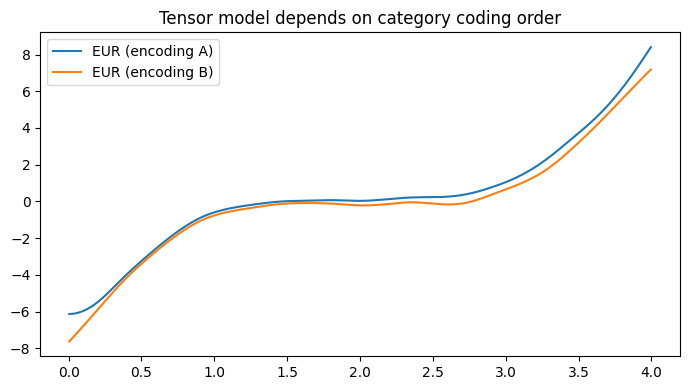

In [14]:
# --- 1) 原编码：USD=0, EUR=1, GBP=2
code_a = np.select([x2=="USD", x2=="EUR", x2=="GBP"], [0,1,2])
X_te_a = np.column_stack([x1, code_a])

gam_te_a = LinearGAM(te(0, 1, n_splines=[25, 6], spline_order=[3, 3])).fit(X_te_a, y)

# --- 2) 换编码：USD=0, EUR=2, GBP=1  (只换 EUR/GBP 的顺序)
code_b = np.select([x2=="USD", x2=="EUR", x2=="GBP"], [0,2,1])
X_te_b = np.column_stack([x1, code_b])

gam_te_b = LinearGAM(te(0, 1, n_splines=[25, 6], spline_order=[3, 3])).fit(X_te_b, y)

# grid
xg = np.linspace(x1.min(), x1.max(), 300)

def pred_for(model, code):
    return model.predict(np.column_stack([xg, np.full_like(xg, code)]))

# compare predictions for "EUR" under two encodings
eur_a = pred_for(gam_te_a, 1)  # EUR code=1 in A
eur_b = pred_for(gam_te_b, 2)  # EUR code=2 in B

print("max |EUR_pred(A)-EUR_pred(B)| =", np.max(np.abs(eur_a - eur_b)))

plt.figure(figsize=(7,4))
plt.plot(xg, eur_a, label="EUR (encoding A)")
plt.plot(xg, eur_b, label="EUR (encoding B)")
plt.title("Tensor model depends on category coding order")
plt.legend()
plt.tight_layout()
plt.show()
